# Implimentation of a Wide ResNet with dropout


In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import torch
from trainers import ClassifierTrainer
from wide_resnet_dropout_v2 import make_resnet_architecture, BasicBlock, WideResnet
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms as Tr
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import random

C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class CIFARDataset(Dataset):

    def __init__(self,path,filenames,transform=None):
        self.data_dict = self.load_data(path,filenames)
        self.class_names = self.unpickle(os.path.join(path,'batches.meta'))[b'label_names']
        self.class_names = list(map(lambda x: x.decode('UTF-8'), self.class_names))
        self.images = self.data_dict[b'data'].reshape(-1,3,32,32)
        self.labels = self.data_dict[b'labels']
        self.transform = transform
        
    def __getitem__(self,index):
        # Get one item from the dataset
        sample = self.images[index]
        if self.transform:
            img = Image.fromarray(sample.T)
            sample = np.asanyarray(self.transform(img))
            sample = sample.T
        sample = sample/255
        label = self.labels[index]
        sample = torch.tensor(sample).float()
        label = torch.tensor(label)
        return sample, label
    
    def __len__(self):
        return len(self.images)
    
    def load_data(self,path,filenames):
        data_dict = {}
        for filename in filenames:
            batch_dict = self.unpickle(os.path.join(path_data,filename))
            if len(data_dict)==0:
                data_dict = batch_dict
            else:
                data_dict[b'labels'] += batch_dict[b'labels']  
                data_dict[b'data'] = np.vstack((data_dict[b'data'],batch_dict[b'data']))
        return data_dict
    
    def unpickle(self,file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

In [3]:
def show_sample_image(dataset, idx=0, add_title=True, ax=None):
    image, label = dataset[idx]
    label = int(label.item())
    image = image.numpy().T
    flipped_image = np.zeros(image.shape)
    flipped_image[:,:, 0] = image[:,:, 0].T
    flipped_image[:,:, 1] = image[:,:, 1].T
    flipped_image[:,:, 2] = image[:,:, 2].T
    label_name = dataset.class_names[label]
    if ax is None:
        _, ax = plt.subplots(figsize=(1,1))
    ax.imshow(flipped_image, interpolation='nearest')
    ax.set_xticks([])
    ax.set_yticks([])
    if add_title:
        ax.set_title(label_name)
    return flipped_image, label, label_name, ax

# Setup the datasets

In [4]:
path_data = './data/cifar-10-batches-py/'
batchfiles = os.listdir(path_data)
train_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
test_batches = ['test_batch']

batch_size = 100

### Data Augmentation

In [5]:
#transforms = Tr.AutoAugment(Tr.AutoAugmentPolicy.CIFAR10)
transforms = Tr.Compose([Tr.Pad(4),
                         Tr.RandomHorizontalFlip(),
                         Tr.RandomCrop(32)])


In [6]:
train_dataset = CIFARDataset(path_data, train_batches, transform=transforms)
test_dataset = CIFARDataset(path_data, test_batches)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size,
                                           shuffle=False)

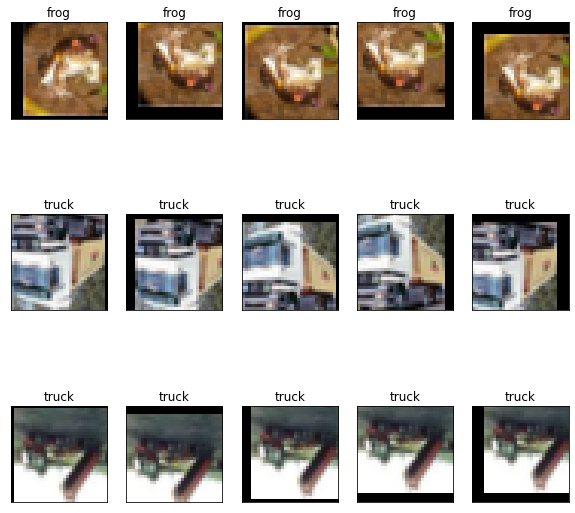

In [7]:
dataset = train_dataset

nrows = 3
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))


for i in range(nrows):
    for j in range(ncols):
        image, _, _, ax = show_sample_image(dataset, i,ax=axs[i,j], add_title=True)
    

# Train the mdel

**ResNet architecture with k=1**

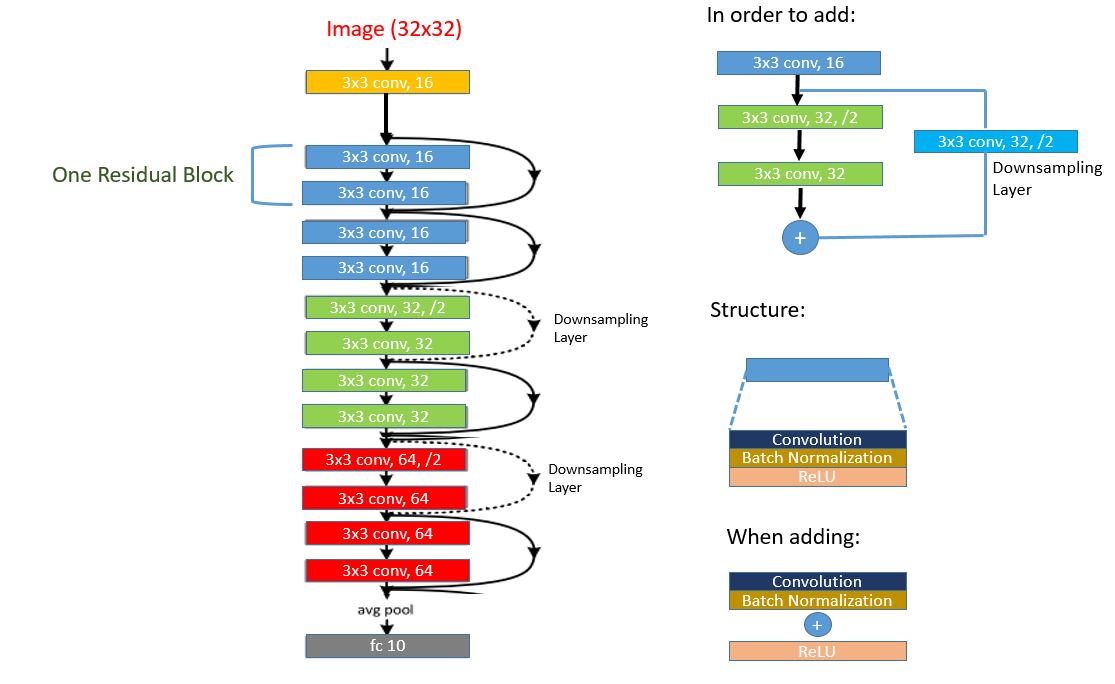

In [8]:
# Make model architecture (28-10)
architecture = make_resnet_architecture(k=10, block_sizes=[4, 4, 4], Pdropout=0.3)

In [9]:
#Learning rate
learning_rate = 0.1
#Number of pochs
num_epochs = 200
#Initialize the model
model = WideResnet(architecture, BasicBlock)
#Define the optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
# Create a learning rate scheduler
scheduler = StepLR(optimizer, step_size=60, gamma=0.2)
#scheduler = None

In [10]:
trainer = ClassifierTrainer(model, optimizer,
                            train_loader, test_loader, False, scheduler)

In [11]:
%%time
trainer.fit(num_epochs)

Epoch 1/200, Training Loss: 1.823, Training Accuracy: 0.312, Testing Loss: 2.253, Testing Acc: 0.308
Epoch 2/200, Training Loss: 1.432, Training Accuracy: 0.471, Testing Loss: 2.053, Testing Acc: 0.372
Epoch 3/200, Training Loss: 1.226, Training Accuracy: 0.556, Testing Loss: 1.361, Testing Acc: 0.534
Epoch 4/200, Training Loss: 1.112, Training Accuracy: 0.600, Testing Loss: 2.977, Testing Acc: 0.378
Epoch 5/200, Training Loss: 1.044, Training Accuracy: 0.627, Testing Loss: 1.794, Testing Acc: 0.473
Epoch 6/200, Training Loss: 1.004, Training Accuracy: 0.642, Testing Loss: 2.307, Testing Acc: 0.391
Epoch 7/200, Training Loss: 0.964, Training Accuracy: 0.657, Testing Loss: 1.885, Testing Acc: 0.448
Epoch 8/200, Training Loss: 0.922, Training Accuracy: 0.672, Testing Loss: 1.148, Testing Acc: 0.598
Epoch 9/200, Training Loss: 0.894, Training Accuracy: 0.684, Testing Loss: 1.001, Testing Acc: 0.641
Epoch 10/200, Training Loss: 0.861, Training Accuracy: 0.696, Testing Loss: 1.821, Testing 

Epoch 82/200, Training Loss: 0.272, Training Accuracy: 0.905, Testing Loss: 0.851, Testing Acc: 0.744
Epoch 83/200, Training Loss: 0.267, Training Accuracy: 0.909, Testing Loss: 0.588, Testing Acc: 0.821
Epoch 84/200, Training Loss: 0.267, Training Accuracy: 0.907, Testing Loss: 0.576, Testing Acc: 0.825
Epoch 85/200, Training Loss: 0.267, Training Accuracy: 0.906, Testing Loss: 0.486, Testing Acc: 0.845
Epoch 86/200, Training Loss: 0.265, Training Accuracy: 0.908, Testing Loss: 0.553, Testing Acc: 0.831
Epoch 87/200, Training Loss: 0.259, Training Accuracy: 0.910, Testing Loss: 0.541, Testing Acc: 0.830
Epoch 88/200, Training Loss: 0.263, Training Accuracy: 0.905, Testing Loss: 0.605, Testing Acc: 0.821
Epoch 89/200, Training Loss: 0.262, Training Accuracy: 0.911, Testing Loss: 0.596, Testing Acc: 0.825
Epoch 90/200, Training Loss: 0.261, Training Accuracy: 0.909, Testing Loss: 0.635, Testing Acc: 0.805
Epoch 91/200, Training Loss: 0.253, Training Accuracy: 0.912, Testing Loss: 0.474,

Epoch 162/200, Training Loss: 0.030, Training Accuracy: 0.991, Testing Loss: 0.368, Testing Acc: 0.903
Epoch 163/200, Training Loss: 0.032, Training Accuracy: 0.991, Testing Loss: 0.401, Testing Acc: 0.900
Epoch 164/200, Training Loss: 0.031, Training Accuracy: 0.991, Testing Loss: 0.425, Testing Acc: 0.892
Epoch 165/200, Training Loss: 0.034, Training Accuracy: 0.990, Testing Loss: 0.473, Testing Acc: 0.882
Epoch 166/200, Training Loss: 0.036, Training Accuracy: 0.989, Testing Loss: 0.409, Testing Acc: 0.897
Epoch 167/200, Training Loss: 0.037, Training Accuracy: 0.989, Testing Loss: 0.427, Testing Acc: 0.894
Epoch 168/200, Training Loss: 0.035, Training Accuracy: 0.990, Testing Loss: 0.419, Testing Acc: 0.893
Epoch 169/200, Training Loss: 0.033, Training Accuracy: 0.991, Testing Loss: 0.397, Testing Acc: 0.899
Epoch 170/200, Training Loss: 0.032, Training Accuracy: 0.991, Testing Loss: 0.395, Testing Acc: 0.901
Epoch 171/200, Training Loss: 0.036, Training Accuracy: 0.989, Testing Lo

In [12]:
model_file = './models/cifar10_wrn_170922'
trainer.save_model(model_file)

# Model Evaluation

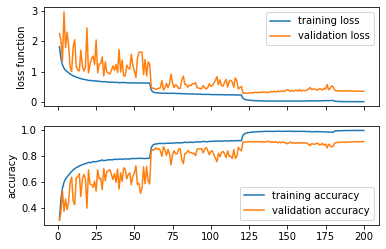

In [13]:
epochs = list(range(1,num_epochs+1))

fig, axs = plt.subplots(2,1,sharex=True)
axs[0].plot(epochs, trainer.train_losses)
axs[0].plot(epochs, trainer.test_losses)
axs[0].set_ylabel('loss function')
axs[0].legend(['training loss', 'validation loss'])
axs[1].plot(epochs, trainer.train_accuracies)
axs[1].plot(epochs, trainer.test_accuracies)
axs[1].set_ylabel('accuracy')
axs[1].legend(['training accuracy', 'validation accuracy'])

In [14]:
trainer.test_accuracies[-1]

0.9133999347686768

# Visualize predictions

accuracy for the presented 25 images: 0.92


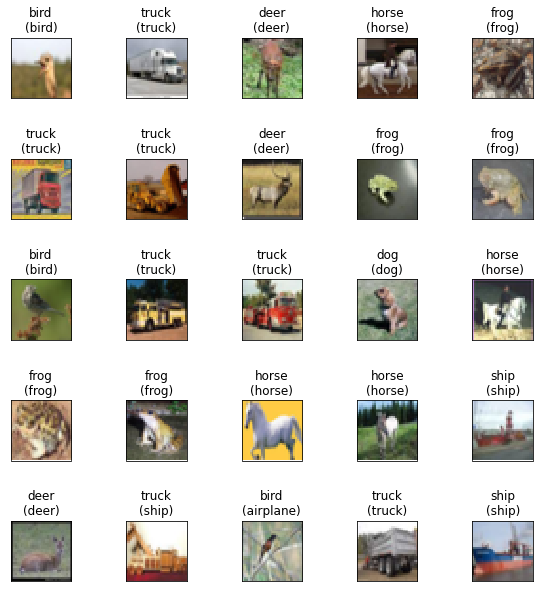

In [16]:
dataset = test_dataset

nrows = 5
ncols = 5
fig, axs = plt.subplots(nrows, ncols, squeeze=False, figsize=(10,10))

accuracy = 0

for i in range(nrows):
    for j in range(ncols):
        idx = random.randint(0,len(dataset)-1)
        prediction = trainer.predict(dataset, idx)
        prediction_name = dataset.class_names[prediction]
        _, label, label_name, ax = show_sample_image(dataset, idx,ax=axs[i,j], add_title=False)
        ax.set_title(label_name + '\n(' + prediction_name +')')
        plt.subplots_adjust(hspace=1)
        accuracy +=1/(nrows*ncols)*float(prediction==label)
        
print('accuracy for the presented '+str(nrows*ncols)+' images: '+str(round(accuracy,2)))